# Hands-On Pertemuan 9: Spark SQL

## Tujuan:
- Mengasah keterampilan analisis data menggunakan Spark SQL.
- Melakukan lebih banyak latihan SQL yang mengarah ke skenario dunia nyata.
- Mempersiapkan mahasiswa untuk menggunakan Spark SQL dalam proyek besar.


### 1. Refresher: Basic SQL Operations in Spark SQL
- **Tugas 1**: Ulangi pemahaman Anda tentang SQL dasar dengan menjalankan queries sederhana pada dataset di Spark SQL.


In [ ]:
!pip install spark
!pip install pyspark
!pip install pandas

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.0/41.0 kB 1.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for spark: filename=spark-0.2.1-py3-none-any.whl size=58748 sha256=c39ce65dde38d5172d7357691f6faa5ebbd2b5ff1d55461af65852878d695565
  Stored in directory: /root/.cache/pip/wheels/63/88/77/b4131110ea4094540f7b47c6d62a649807d7e94800da5eab0b
Successfully built spark


In [ ]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("Tafrispark").getOrCreate()

In [ ]:
data = [
    ('James', 34, 'M', 3000, 1),
    ('Anna', 28, 'F', 4100, 2),
    ('Lee', 23, 'M', 2700, 1)
]
columns = ['Name', 'Age', 'Gender', 'Salary', 'DeptId']
df = spark.createDataFrame(data, schema=columns)
df.createOrReplaceTempView('employees')
spark.sql('SELECT * FROM employees').show()
spark.sql('SELECT Name, Age FROM employees WHERE Salary > 3000').show()
spark.sql('SELECT AVG(Salary) FROM employees').show()


+-----+---+------+------+------+
| Name|Age|Gender|Salary|DeptId|
+-----+---+------+------+------+
|James| 34|     M|  3000|     1|
| Anna| 28|     F|  4100|     2|
|  Lee| 23|     M|  2700|     1|
+-----+---+------+------+------+

+----+---+
|Name|Age|
+----+---+
|Anna| 28|
+----+---+

+------------------+
|       avg(Salary)|
+------------------+
|3266.6666666666665|
+------------------+



### 2. Advanced Queries for Data Analysis
Gunakan queries lebih kompleks, melibatkan grouping, filtering, dan subqueries.
- **Tugas 2**: Buat SQL query yang menghitung total gaji berdasarkan jenis kelamin dan usia.


In [ ]:
spark.sql('''
SELECT Gender, SUM(Salary) as TotalSalary, Age
FROM employees
GROUP BY Gender, Age
ORDER BY Age
''').show()


+------+-----------+---+
|Gender|TotalSalary|Age|
+------+-----------+---+
|     M|       2700| 23|
|     F|       4100| 28|
|     M|       3000| 34|
+------+-----------+---+



- **Tugas Tambahan 2**:
1. Cari rata-rata gaji per departemen.
2. Temukan karyawan yang memiliki gaji di atas rata-rata untuk gender masing-masing.
3. Buat ranking karyawan berdasarkan gaji dalam departemen mereka.


In [ ]:
# 1. rata-rata gaji per departemen.
spark.sql('''
    SELECT DeptId, AVG(Salary) as AvgSalary
    FROM employees
    GROUP BY DeptId
    ORDER BY DeptId
''').show()

+------+---------+
|DeptId|AvgSalary|
+------+---------+
|     1|   2850.0|
|     2|   4100.0|
+------+---------+



In [ ]:
# 2. karyawan yang memiliki gaji di atas rata-rata untuk gender masing-masing
spark.sql('''
    WITH GenderAvg AS (
        SELECT Gender, AVG(Salary) as AvgSalary
        FROM employees
        GROUP BY Gender
    )
    SELECT
        e.Name, e.Gender, e.Salary,g.AvgSalary as GenderAvgSalary
    FROM employees e
    INNER JOIN GenderAvg g ON e.Gender = g.Gender
    WHERE e.Salary >= g.AvgSalary
    ORDER BY e.Gender, e.Salary DESC
''').show()

+-----+------+------+---------------+
| Name|Gender|Salary|GenderAvgSalary|
+-----+------+------+---------------+
| Anna|     F|  4100|         4100.0|
|James|     M|  3000|         2850.0|
+-----+------+------+---------------+



In [ ]:
# 3. ranking karyawan berdasarkan gaji dalam departemen masing masing
spark.sql('''
    SELECT
        Name, DeptId, Salary,
        RANK() OVER (PARTITION BY DeptId ORDER BY Salary DESC) as SalaryRank
    FROM employees
    ORDER BY DeptId, SalaryRank
''').show()

+-----+------+------+----------+
| Name|DeptId|Salary|SalaryRank|
+-----+------+------+----------+
|James|     1|  3000|         1|
|  Lee|     1|  2700|         2|
| Anna|     2|  4100|         1|
+-----+------+------+----------+



### 3. Penggunaan Window Functions dan Subqueries
Latihan penggunaan window functions untuk menemukan karyawan dengan gaji tertinggi dan urutannya berdasarkan kelompok usia.
- **Tugas 3**: Terapkan window functions untuk menemukan top 3 karyawan dalam kelompok usia tertentu.


In [ ]:
spark.sql('''
SELECT Name, Age, Salary, ROW_NUMBER() OVER (PARTITION BY Age ORDER BY Salary DESC) as rank
FROM employees
''').show()


+-----+---+------+----+
| Name|Age|Salary|rank|
+-----+---+------+----+
|  Lee| 23|  2700|   1|
| Anna| 28|  4100|   1|
|James| 34|  3000|   1|
+-----+---+------+----+



### 4. Advanced Spark SQL Queries
Menjelajahi queries yang lebih kompleks yang melibatkan multiple joins, subqueries, dan window functions.
- **Tugas 4**: Demonstrasi penggunaan multi-level joins dan subqueries untuk analisis data yang mendalam.


In [ ]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('Pertemuan9').getOrCreate()

# Data setup for complex SQL queries
employees = spark.createDataFrame([
    ('James', 34, 'M', 3000, 1),
    ('Anna', 28, 'F', 4100, 2),
    ('Lee', 23, 'M', 2700, 1)
], ['Name', 'Age', 'Gender', 'Salary', 'DeptId'])
departments = spark.createDataFrame([
    (1, 'HR'),
    (2, 'Marketing')
], ['DeptId', 'DeptName'])
projects = spark.createDataFrame([
    (1, 'Project A'),
    (2, 'Project B')
], ['DeptId', 'ProjectName'])
employees.createOrReplaceTempView('employees')
departments.createOrReplaceTempView('departments')
projects.createOrReplaceTempView('projects')

# Complex SQL query involving multiple joins and subqueries
spark.sql('''
SELECT e.Name, e.Age, d.DeptName, p.ProjectName
FROM employees e
JOIN departments d ON e.DeptId = d.DeptId
JOIN projects p ON e.DeptId = p.DeptId
''').show()


+-----+---+---------+-----------+
| Name|Age| DeptName|ProjectName|
+-----+---+---------+-----------+
|  Lee| 23|       HR|  Project A|
|James| 34|       HR|  Project A|
| Anna| 28|Marketing|  Project B|
+-----+---+---------+-----------+



Latihan mandiri untuk memperkuat pemahaman tentang Spark SQL dalam analisis data terdistribusi.
- **Tugas 5**: Tuliskan query SQL untuk menemukan rata-rata gaji per departemen dan rangking setiap karyawan dalam departemen berdasarkan gaji.
- **Tugas 6**: Gunakan window functions untuk menentukan tren gaji berdasarkan usia di setiap departemen.


In [ ]:
# query SQL untuk menemukan rata-rata gaji per departemen dan rangking setiap karyawan dalam departemen berdasarkan gaji
spark.sql('''
    WITH DeptAvg AS (
        SELECT
            d.DeptName,
            AVG(e.Salary) as AvgDeptSalary
        FROM employees e
        JOIN departments d ON e.DeptId = d.DeptId
        GROUP BY d.DeptName
    )
    SELECT
        e.Name, d.DeptName, e.Salary, da.AvgDeptSalary,
        RANK() OVER (PARTITION BY d.DeptName ORDER BY e.Salary DESC) as SalaryRank
    FROM employees e
    JOIN departments d ON e.DeptId = d.DeptId
    JOIN DeptAvg da ON d.DeptName = da.DeptName
    ORDER BY d.DeptName, SalaryRank
''').show()

+-----+---------+------+-------------+----------+
| Name| DeptName|Salary|AvgDeptSalary|SalaryRank|
+-----+---------+------+-------------+----------+
|James|       HR|  3000|       2850.0|         1|
|  Lee|       HR|  2700|       2850.0|         2|
| Anna|Marketing|  4100|       4100.0|         1|
+-----+---------+------+-------------+----------+



In [ ]:
# window functions untuk menentukan tren gaji berdasarkan usia di setiap departemen
spark.sql('''
    SELECT
        d.DeptName,
        e.Name,
        e.Age,
        e.Salary,
        AVG(e.Salary) OVER (PARTITION BY d.DeptName) as AvgDeptSalary,
        CASE
            WHEN e.Salary > AVG(e.Salary) OVER (PARTITION BY d.DeptName) THEN 'Above Average'
            ELSE 'Below Average'
        END as SalaryStatus
    FROM employees e
    JOIN departments d ON e.DeptId = d.DeptId
    ORDER BY d.DeptName, e.Age
''').show()

+---------+-----+---+------+-------------+-------------+
| DeptName| Name|Age|Salary|AvgDeptSalary| SalaryStatus|
+---------+-----+---+------+-------------+-------------+
|       HR|  Lee| 23|  2700|       2850.0|Below Average|
|       HR|James| 34|  3000|       2850.0|Above Average|
|Marketing| Anna| 28|  4100|       4100.0|Below Average|
+---------+-----+---+------+-------------+-------------+



### 5. Advanced Data Analysis and Visualization
Penerapan teknik analisis data yang lebih canggih dan visualisasi menggunakan PySpark dan matplotlib.
- **Tugas 7**: Lakukan analisis tren gaji menggunakan Spark SQL dan visualisasikan hasilnya.


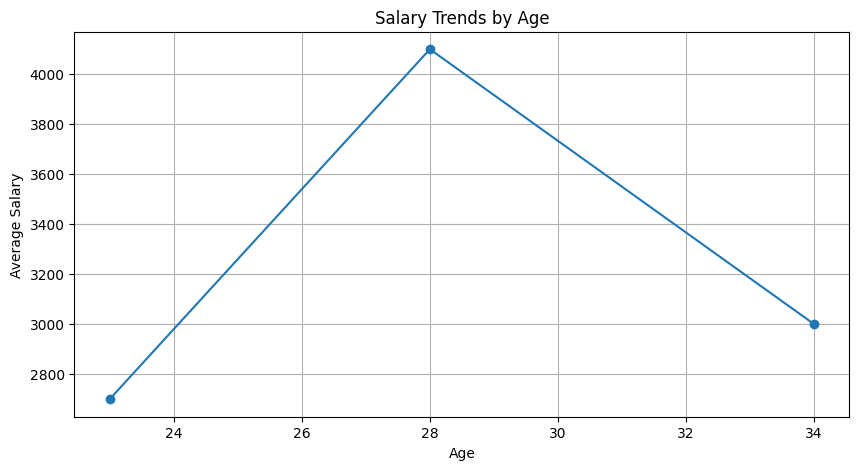

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Advanced data analysis with visualization
salary_trends = spark.sql('''
SELECT Age, AVG(Salary) AS AverageSalary
FROM employees
GROUP BY Age
ORDER BY Age
''').toPandas()

# Visualization of salary trends
plt.figure(figsize=(10, 5))
plt.plot(salary_trends['Age'], salary_trends['AverageSalary'], marker='o')
plt.xlabel('Age')
plt.ylabel('Average Salary')
plt.title('Salary Trends by Age')
plt.grid(True)
plt.show()


### 6. Homework
- **Tugas 1**: Gunakan Spark SQL untuk mencari total gaji dan jumlah karyawan per departemen. Buat visualisasi perbandingan antar departemen.
- **Tugas 2**: Temukan karyawan dengan gaji di atas rata-rata dalam setiap kelompok usia dan visualisasikan data ini dalam bentuk grafik batang atau pie chart.
- **Tugas 3**: Buat dataset yang lebih besar (misalnya, 100+ baris) dan lakukan analisis mendalam menggunakan SQL functions seperti `SUM()`, `AVG()`, `COUNT()`, serta `JOIN` antar tabel serta buat visualisasi yang menarik.


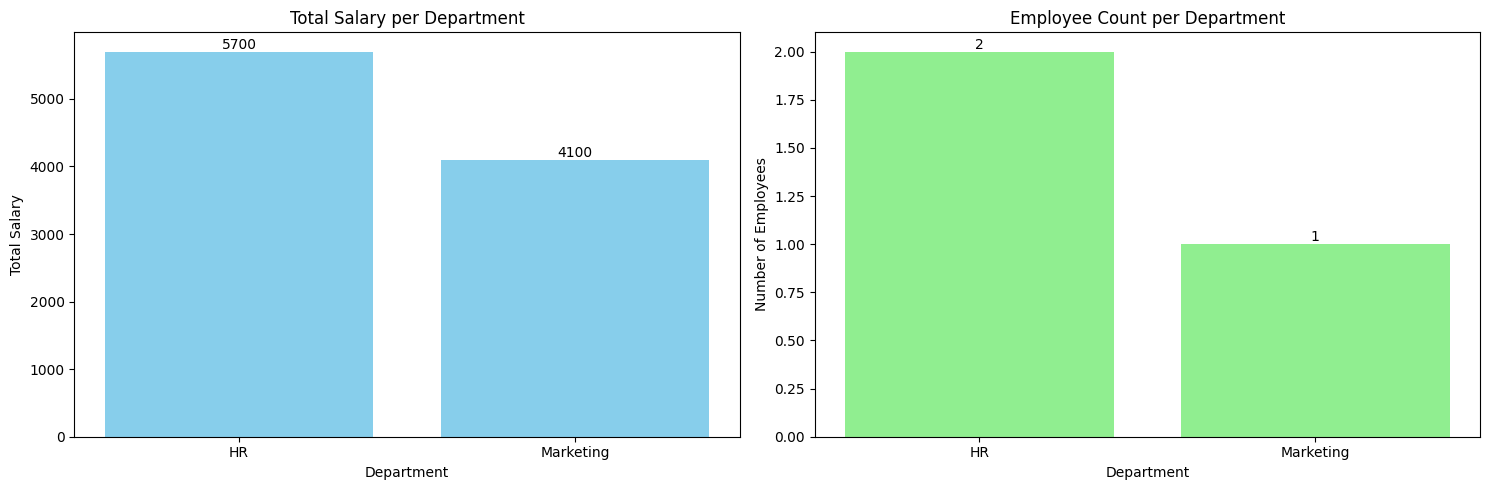

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Tugas 1: Visualisasi total gaji dan jumlah karyawan per departemen
dept_summary = spark.sql('''
    SELECT
        d.DeptName,
        COUNT(e.Name) as EmpCount,
        SUM(e.Salary) as TotalSalary,
        AVG(e.Salary) as AvgSalary
    FROM employees e
    JOIN departments d ON e.DeptId = d.DeptId
    GROUP BY d.DeptName
    ORDER BY d.DeptName
''')

# Convert Spark DataFrame to Pandas for visualization
dept_df = dept_summary.toPandas()

# Membuat subplot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot 1: Total Salary per Department
ax1.bar(dept_df['DeptName'], dept_df['TotalSalary'], color='skyblue')
ax1.set_title('Total Salary per Department')
ax1.set_xlabel('Department')
ax1.set_ylabel('Total Salary')
for i, v in enumerate(dept_df['TotalSalary']):
    ax1.text(i, v, str(v), ha='center', va='bottom')

# Plot 2: Employee Count per Department
ax2.bar(dept_df['DeptName'], dept_df['EmpCount'], color='lightgreen')
ax2.set_title('Employee Count per Department')
ax2.set_xlabel('Department')
ax2.set_ylabel('Number of Employees')
for i, v in enumerate(dept_df['EmpCount']):
    ax2.text(i, v, str(v), ha='center', va='bottom')

plt.tight_layout()
plt.show()

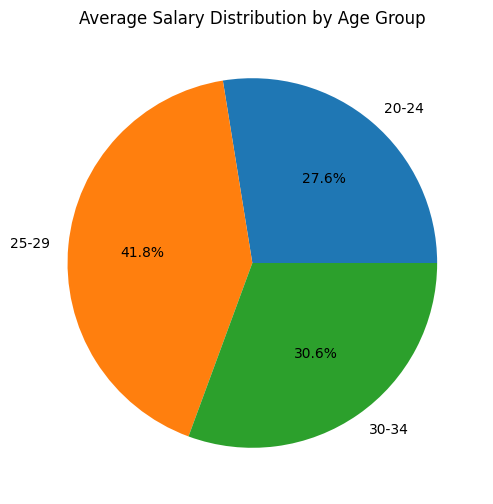

In [ ]:
# Tugas 2: Visualisasi gaji berdasarkan kelompok usia
age_salary = spark.sql('''
    WITH AgeGroup AS (
        SELECT
            CASE
                WHEN Age < 25 THEN '20-24'
                WHEN Age < 30 THEN '25-29'
                WHEN Age < 35 THEN '30-34'
                ELSE '35+'
            END as AgeGroup,
            Salary
        FROM employees
    )
    SELECT
        AgeGroup,
        AVG(Salary) as AvgSalary,
        COUNT(*) as EmpCount
    FROM AgeGroup
    GROUP BY AgeGroup
    ORDER BY AgeGroup
''')

age_df = age_salary.toPandas()

# Membuat pie chart untuk rata-rata gaji per kelompok usia
plt.figure(figsize=(10, 6))
plt.pie(age_df['AvgSalary'], labels=age_df['AgeGroup'], autopct='%1.1f%%')
plt.title('Average Salary Distribution by Age Group')
plt.show()

<ipython-input-42-4781cc351021>:77: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='DeptName', y='AvgSalaryM', data=df, palette='viridis')


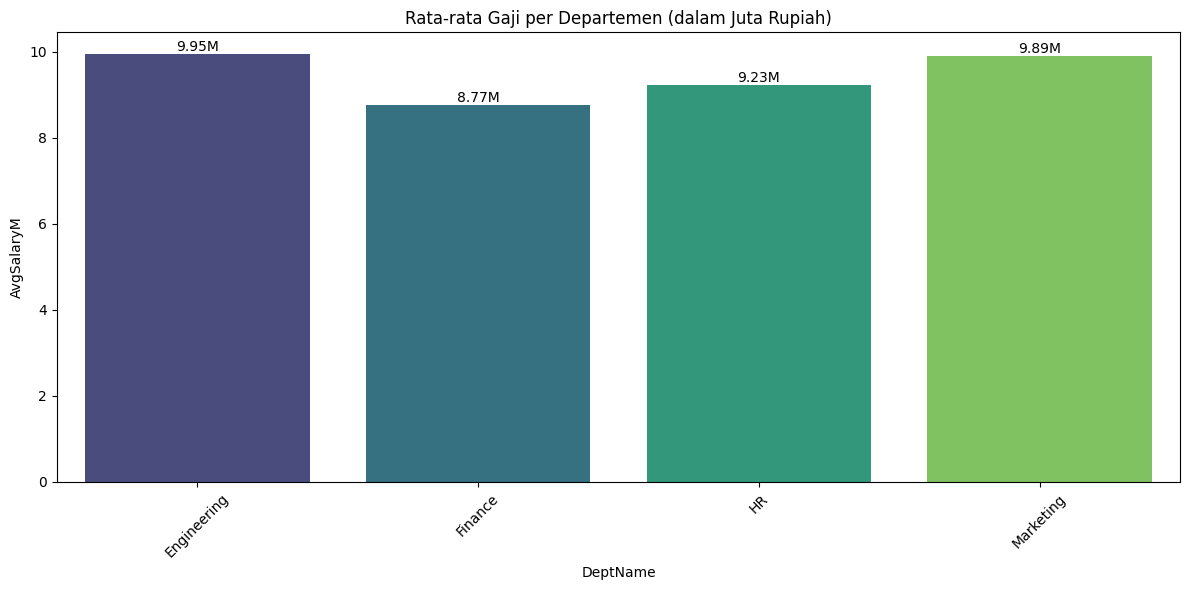

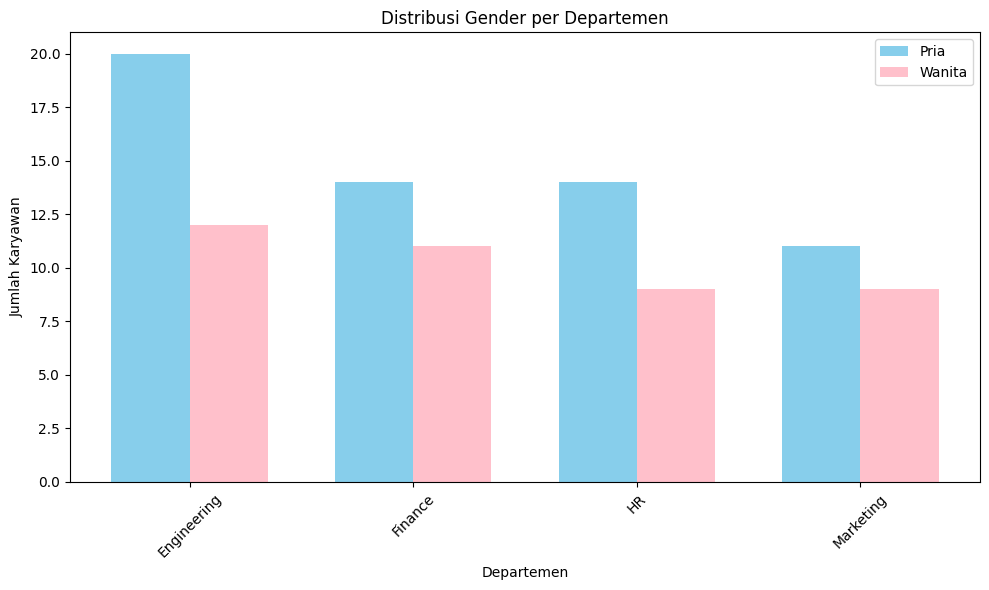

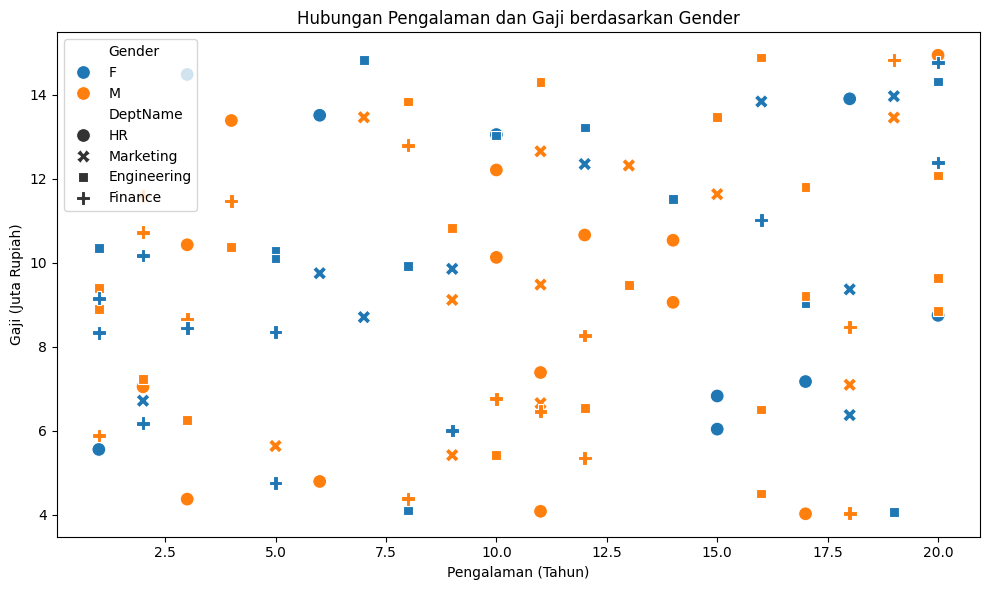

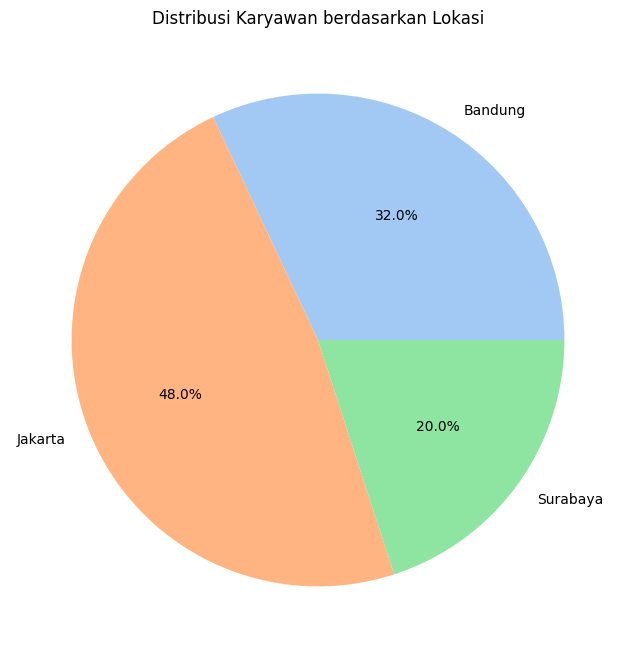

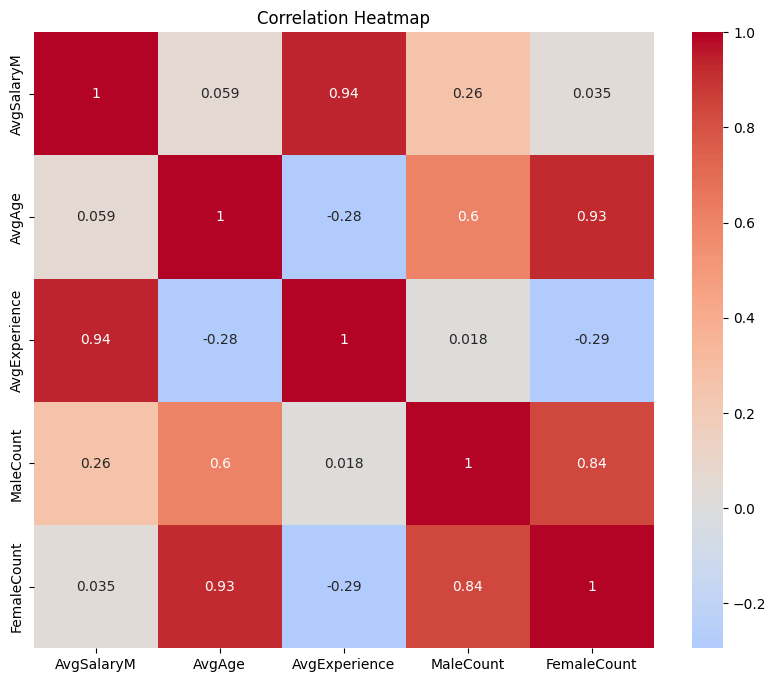


Ringkasan Statistik:
+-----------+--------+--------+----------+----------+----------+--------------+----------------+------+-------------+---------+-----------+
|   DeptName|Location|EmpCount|AvgSalaryM|MinSalaryM|MaxSalaryM|AvgMaleSalaryM|AvgFemaleSalaryM|AvgAge|AvgExperience|MaleCount|FemaleCount|
+-----------+--------+--------+----------+----------+----------+--------------+----------------+------+-------------+---------+-----------+
|Engineering| Bandung|      32|      9.95|      4.06|     14.89|          9.68|            10.4|  39.6|         11.2|       20|         12|
|    Finance| Jakarta|      25|      8.77|      4.03|     14.83|          8.55|            9.05|  39.1|          8.5|       14|         11|
|         HR| Jakarta|      23|      9.23|      4.02|     14.94|          8.79|            9.92|  35.4|         10.5|       14|          9|
|  Marketing|Surabaya|      20|      9.89|      5.42|     13.97|          9.72|            10.1|  37.0|         11.8|       11|          9

In [ ]:
import random
from pyspark.sql.types import *
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# 100 random employees
def generate_employees(n):
    # Daftar nama
    nama_depan = [
        'Budi', 'Siti', 'Ahmad', 'Dewi', 'Eko', 'Ratna', 'Dian', 'Putri',
        'Andi', 'Nina', 'Rudi', 'Sri', 'Agus', 'Maya', 'Hadi', 'Rina',
        'Joko', 'Wati', 'Bambang', 'Ani'
    ]
    nama_belakang = [
        'Wijaya', 'Sari', 'Kusuma', 'Pratama', 'Saputra', 'Utami', 'Nugraha',
        'Dewi', 'Putra', 'Sari', 'Hidayat', 'Wulandari', 'Setiawan', 'Yuliana',
        'Santoso', 'Permata', 'Sutanto', 'Pertiwi', 'Hermawan', 'Rahayu'
    ]

    data = []
    for i in range(n):
        name = f"{random.choice(nama_depan)} {random.choice(nama_belakang)}"
        age = random.randint(22, 55)
        gender = random.choice(['M', 'F'])
        salary = random.randint(4000000, 15000000)  # Gaji dalam Rupiah
        dept_id = random.randint(1, 4)
        experience = random.randint(1, 20)  # Tambahan: pengalaman kerja
        data.append((name, age, gender, salary, dept_id, experience))
    return data

# Membuat DataFrame baru dengan 100 karyawan
large_employees = spark.createDataFrame(
    generate_employees(100),
    ['Name', 'Age', 'Gender', 'Salary', 'DeptId', 'Experience']
)

# Data departemen
departments_data = [
    (1, 'HR', 'Jakarta'),
    (2, 'Marketing', 'Surabaya'),
    (3, 'Engineering', 'Bandung'),
    (4, 'Finance', 'Jakarta')
]
large_departments = spark.createDataFrame(departments_data, ['DeptId', 'DeptName', 'Location'])

# Register temporary views
large_employees.createOrReplaceTempView('employees')
large_departments.createOrReplaceTempView('departments')

# Analisis mendalam
detailed_analysis = spark.sql('''
    SELECT
        d.DeptName,
        d.Location,
        COUNT(*) as EmpCount,
        ROUND(AVG(e.Salary)/1000000, 2) as AvgSalaryM,
        ROUND(MIN(e.Salary)/1000000, 2) as MinSalaryM,
        ROUND(MAX(e.Salary)/1000000, 2) as MaxSalaryM,
        ROUND(AVG(CASE WHEN e.Gender = 'M' THEN e.Salary END)/1000000, 2) as AvgMaleSalaryM,
        ROUND(AVG(CASE WHEN e.Gender = 'F' THEN e.Salary END)/1000000, 2) as AvgFemaleSalaryM,
        ROUND(AVG(e.Age), 1) as AvgAge,
        ROUND(AVG(e.Experience), 1) as AvgExperience,
        COUNT(CASE WHEN e.Gender = 'M' THEN 1 END) as MaleCount,
        COUNT(CASE WHEN e.Gender = 'F' THEN 1 END) as FemaleCount
    FROM employees e
    JOIN departments d ON e.DeptId = d.DeptId
    GROUP BY d.DeptName, d.Location
    ORDER BY d.DeptName
''')

# Convert ke Pandas DataFrame untuk visualisasi
df = detailed_analysis.toPandas()

# 1. Visualisasi Distribusi Gaji per Departemen
plt.figure(figsize=(12, 6))
sns.barplot(x='DeptName', y='AvgSalaryM', data=df, palette='viridis')
plt.title('Rata-rata Gaji per Departemen (dalam Juta Rupiah)')
plt.xticks(rotation=45)
for i, v in enumerate(df['AvgSalaryM']):
    plt.text(i, v, f'{v}M', ha='center', va='bottom')
plt.tight_layout()
plt.show()

# 2. Visualisasi Perbandingan Jumlah Karyawan Pria dan Wanita
plt.figure(figsize=(10, 6))
width = 0.35
x = range(len(df['DeptName']))
plt.bar(x, df['MaleCount'], width, label='Pria', color='skyblue')
plt.bar([i + width for i in x], df['FemaleCount'], width, label='Wanita', color='pink')
plt.xlabel('Departemen')
plt.ylabel('Jumlah Karyawan')
plt.title('Distribusi Gender per Departemen')
plt.xticks([i + width/2 for i in x], df['DeptName'], rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

# 3. Scatter plot Pengalaman vs Gaji dengan Gender
plt.figure(figsize=(10, 6))
exp_salary = spark.sql('''
    SELECT
        Experience,
        Salary/1000000 as SalaryM,
        Gender,
        DeptName
    FROM employees e
    JOIN departments d ON e.DeptId = d.DeptId
''').toPandas()

sns.scatterplot(data=exp_salary, x='Experience', y='SalaryM',
                hue='Gender', style='DeptName', s=100)
plt.title('Hubungan Pengalaman dan Gaji berdasarkan Gender')
plt.xlabel('Pengalaman (Tahun)')
plt.ylabel('Gaji (Juta Rupiah)')
plt.tight_layout()
plt.show()

# 4. Pie Chart Lokasi Kantor
plt.figure(figsize=(8, 8))
location_data = df.groupby('Location')['EmpCount'].sum()
plt.pie(location_data, labels=location_data.index, autopct='%1.1f%%',
        colors=sns.color_palette('pastel'))
plt.title('Distribusi Karyawan berdasarkan Lokasi')
plt.show()

# 5. Heatmap Korelasi
numeric_cols = ['AvgSalaryM', 'AvgAge', 'AvgExperience', 'MaleCount', 'FemaleCount']
correlation = df[numeric_cols].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Heatmap')
plt.show()

# Menampilkan ringkasan statistik
print("\nRingkasan Statistik:")
print(detailed_analysis.show())